# Imports

In [1]:
import torch
import torch.autograd

from multi_cmd.optim import potentials, cmd_utils, gda_utils

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt


# Linear Price and Cost

**TLDR: linear price function, identical linear cost function, pairwise CGD converges to Nash Equilibrium**

Our profit for each player $i$ is defined as the following:
\begin{gather}
\Pi_i = P\left(\sum_j{q_j}\right) \cdot q_i -C_i(q_i) \\
P(q) = 100 - q \\
C_i(q_i) = 10 \cdot q_i
\end{gather}

Thus, to solve for the Nash equilbrium, we take the first derivative and set it to zero:
\begin{gather}
\frac{\partial\Pi_i}{\partial q_i} = \frac{\partial P\left(\sum_j{q_j}\right)}{\partial q_i} \cdot q_i + P\left(\sum_j{q_j}\right) - \frac{\partial C_i (q_i)}{\partial q_i} = 0
\end{gather}

For the example below, this becomes the following:
\begin{gather}
-1 \cdot q_i + \left(100 - \sum_j {q_j}\right) - 10 = 0
\end{gather}

Solving this analytically, we get $q_i = \frac{45}{2}$ (which is what our CGD algorithm converges to)

In [2]:
# Simple linear price, linear cost game.
def player_payoffs(quantity_list):
    quantity_tensor = torch.stack(sum(quantity_list, []))
    price = torch.max(1. - torch.sum(quantity_tensor),
                      torch.tensor(0., requires_grad=True))
                      
    payoffs = []
    for i, quantity in enumerate(quantity_tensor):
        # Negative, since CGD minimizes player objectives.
        payoffs.append(- (quantity * price - 0.1 * quantity))
        
    return payoffs

# Number of iterations and setting up game.
num_iterations = 100
lr = 0.5

# Define individual sellers quantities
x, y, z = 0.1, 0.2, 0.1

# Define player list and optimizers...
player_list_cgd = [
    [torch.tensor([x], requires_grad=True)], 
    [torch.tensor([y], requires_grad=True)], 
    [torch.tensor([z], requires_grad=True)]
]
player_list_gda = [
    [torch.tensor([x], requires_grad=True)], 
    [torch.tensor([y], requires_grad=True)],
    [torch.tensor([z], requires_grad=True)]
]

cgd_optim = cmd_utils.CMD(player_list_cgd, bregman=potentials.shannon_entropy(1/lr), antisymetric=True)
gda_optim = gda_utils.SGD(player_list_gda, lr_list=[lr, lr, lr])

cgd_trajectory1 = [[], [], []]
gda_trajectory1 = [[], [], []]

for i in range(num_iterations):
    # Track trajectory of each optimizer
    for player, traj_list in zip(player_list_cgd, cgd_trajectory1):
        traj_list.append(float(player[0]))
    for player, traj_list in zip(player_list_gda, gda_trajectory1):
        traj_list.append(float(player[0]))
    
    cgd_payoffs = player_payoffs(player_list_cgd)
    cgd_optim.step(cgd_payoffs)
    
    gda_payoffs = player_payoffs(player_list_gda)
    gda_optim.step(gda_payoffs)

print('timesteps, lr:', (num_iterations, lr))
print('final cgd quantities:', [elem[0].detach() for elem in player_list_cgd])
print('final cgd payoffs:', [elem[0].detach() for elem in cgd_payoffs])

print('final gda quantities:', [elem[0].detach() for elem in player_list_gda])
print('final gda payoffs:', [elem[0].detach() for elem in gda_payoffs])


timesteps, lr: (100, 0.5)
final cgd quantities: [tensor([0.2250]), tensor([0.2250]), tensor([0.2250])]
final cgd payoffs: [tensor(-0.0506), tensor(-0.0506), tensor(-0.0506)]
final gda quantities: [tensor([0.1333]), tensor([0.1333]), tensor([0.1333])]
final gda payoffs: [tensor(0.0158), tensor(0.0158), tensor(0.0158)]


<IPython.core.display.Javascript object>


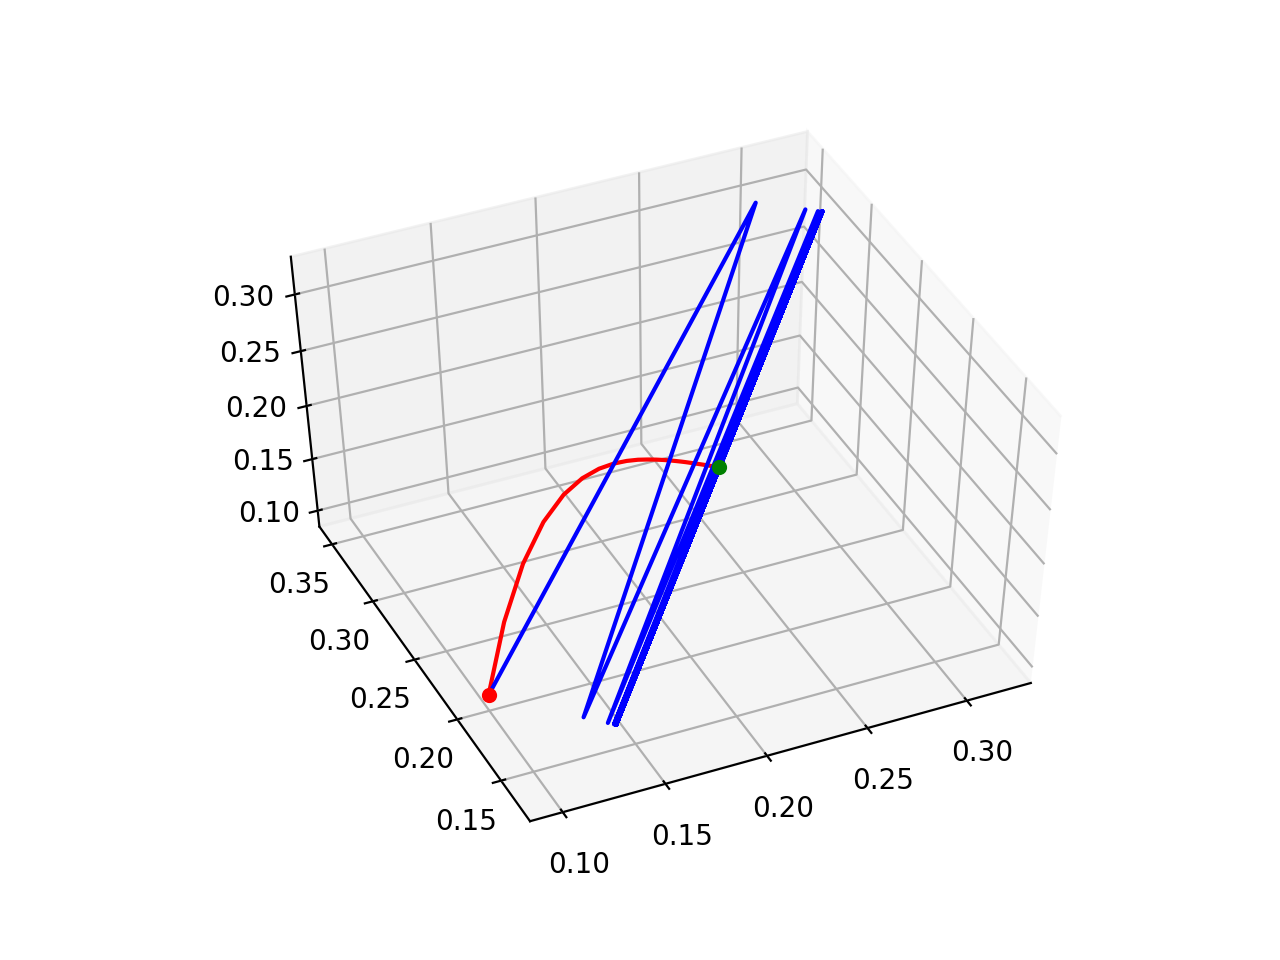

In [3]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(*cgd_trajectory1, 'red')
ax.plot3D(*gda_trajectory1, 'blue')
ax.scatter3D([0.225], [0.225], [0.225], c=['Green']);
ax.scatter3D([x], [y], [z], c=['Red']);

## Quadratic Price Function

**TLDR: quadratic price function, identical linear cost function, pairwise CGD converges to Nash Equilibrium (with learning rate tuning)**

Our profit for each player $i$ is defined as the following:
\begin{gather}
\Pi_i = P\left(\sum_j{q_j}\right) \cdot q_i -C_i(q_i) \\
P(q) = 100 - \sum_j{q_j^2} \\
C_i(q_i) = 10 \cdot q_i
\end{gather}

Thus, to solve for the Nash equilbrium, we take the first derivative and set it to zero:
\begin{gather}
\frac{\partial\Pi_i}{\partial q_i} = \frac{\partial P\left(\sum_j{q_j}\right)}{\partial q_i} \cdot q_i + P\left(\sum_j{q_j}\right) - \frac{\partial C_i (q_i)}{\partial q_i} = 0
\end{gather}

For the example below, this becomes the following:
\begin{gather}
-2 \cdot q_i^2 + \left(100 - \sum_j {q_j^2}\right) - 10 = 0 \\
90 = \sum_{i\neq j} {q_j^2} - 3 q_i^2
\end{gather}

Solving this, we have multiple Nash Equlibrium, but the only solution with all non-negative quantities (as defined by our bregman divergence constraints), we get $q_i = \sqrt{18} = 4.24$ (which is what our algorithm converges to).

In [4]:
# Simple quadratic price, linear cost game.
def player_payoffs(quantity_list):
    quantity_tensor = torch.stack(sum(quantity_list, []))
    price = torch.max(
        100 - torch.sum(torch.pow(quantity_tensor, 2)),
        torch.tensor(0., requires_grad=True)
    )
                      
    payoffs = []
    for i, quantity in enumerate(quantity_tensor):
        # Negative, since CGD minimizes player objectives.
        payoffs.append(- (quantity * price - 10 * quantity))
        
    return payoffs

# Number of iterations and setting up game.
num_iterations = 5
lr = 0.01

# Define individual sellers quantities
x, y, z = 1., 2., 1.

# Define player list and optimizers...
player_list_cgd = [
    [torch.tensor([x], requires_grad=True)], 
    [torch.tensor([y], requires_grad=True)], 
    [torch.tensor([z], requires_grad=True)]
]
player_list_gda = [
    [torch.tensor([x], requires_grad=True)], 
    [torch.tensor([y], requires_grad=True)], 
    [torch.tensor([z], requires_grad=True)]
]

cgd_optim = cmd_utils.CMD(player_list_cgd, bregman=potentials.shannon_entropy(1/lr))
gda_optim = gda_utils.SGD(player_list_gda, lr_list=[lr, lr, lr])

cgd_trajectory2 = [[], [], []]
gda_trajectory2 = [[], [], []]

for i in range(num_iterations):
    # Track trajectory of each optimizer
    for player, traj_list in zip(player_list_cgd, cgd_trajectory2):
        traj_list.append(float(player[0]))
    for player, traj_list in zip(player_list_gda, gda_trajectory2):
        traj_list.append(float(player[0]))
    
    cgd_payoffs = player_payoffs(player_list_cgd)
    cgd_optim.step(cgd_payoffs)
    
    gda_payoffs = player_payoffs(player_list_gda)
    gda_optim.step(gda_payoffs)

print('final cgd quantities:', [elem[0].detach() for elem in player_list_cgd])
print('final cgd payoffs:', [elem[0].detach() for elem in cgd_payoffs])

print('final gda quantities:', [elem[0].detach() for elem in player_list_gda])
print('final gda payoffs:', [elem[0].detach() for elem in gda_payoffs])

final cgd quantities: [tensor([4.2431]), tensor([4.2416]), tensor([4.2431])]
final cgd payoffs: [tensor(-152.5369), tensor(-152.9719), tensor(-152.5369)]
final gda quantities: [tensor([3.6932]), tensor([4.2458]), tensor([3.6932])]
final gda payoffs: [tensor(-170.8755), tensor(-203.2722), tensor(-170.8755)]


<IPython.core.display.Javascript object>


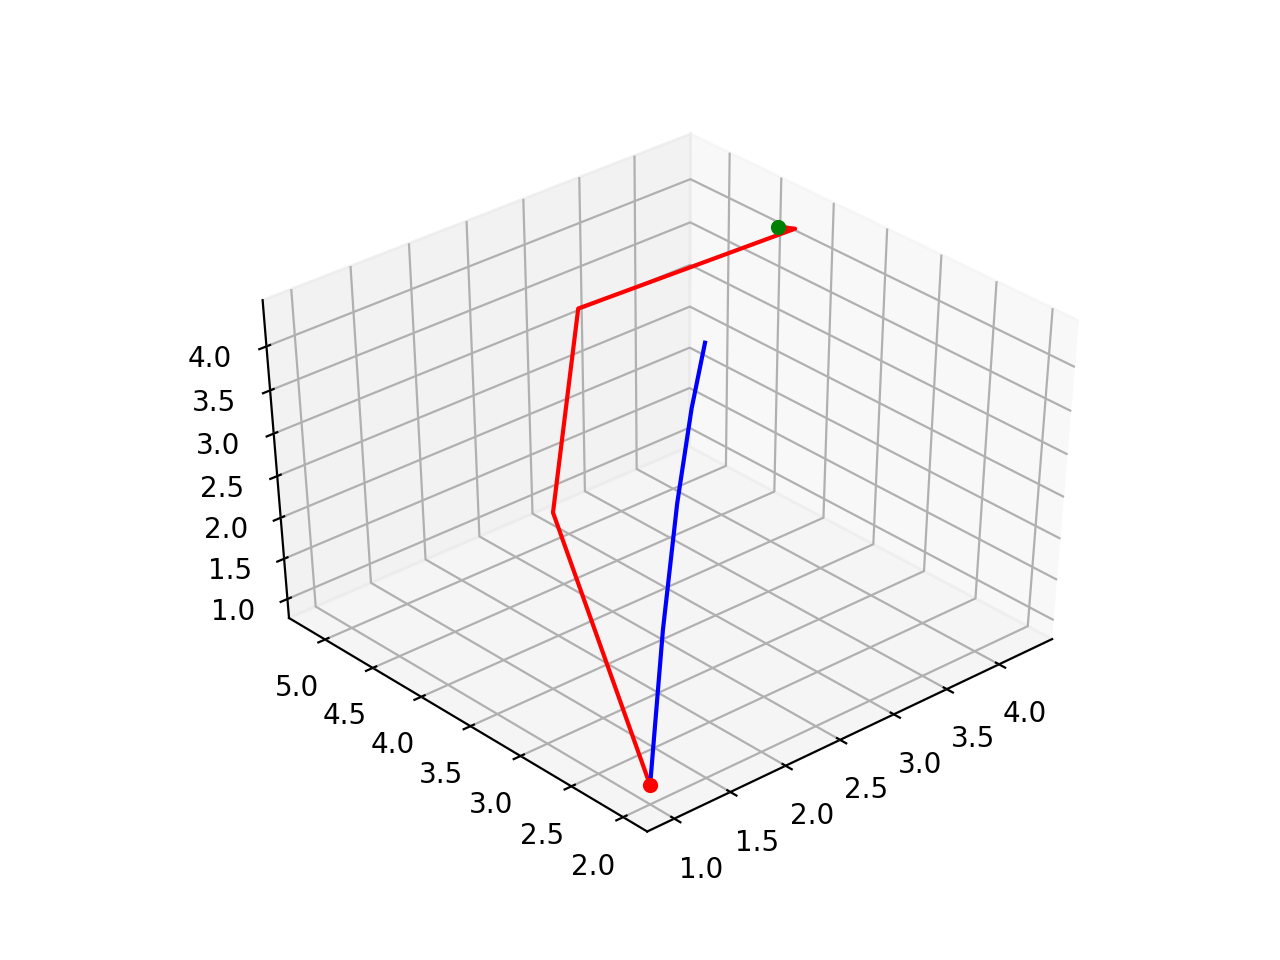

In [5]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(*cgd_trajectory2, 'red')
ax.plot3D(*gda_trajectory2, 'blue')
ax.scatter3D([4.2426], [4.2426], [4.2426], c=['Green']);
ax.scatter3D([x], [y], [z], c=['Red']);

## Non-linear Cost Function

**TLDR: linear price function, identical non-linear cost function (simulating at-scale production), pairwise CGD converges to Nash Equilibrium**

Our profit for each player $i$ is defined as the following:
\begin{gather}
\Pi_i = P\left(\sum_j{q_j}\right) \cdot q_i -C_i(q_i) \\
P(q) = 100 - q \\
C_i(q_i) = 10 \cdot \left(\frac{10}{x+10}\right)
\end{gather}

Thus, to solve for the Nash equilbrium, we take the first derivative and set it to zero:
\begin{gather}
\frac{\partial\Pi_i}{\partial q_i} = \frac{\partial P\left(\sum_j{q_j}\right)}{\partial q_i} \cdot q_i + P\left(\sum_j{q_j}\right) - \frac{\partial C_i (q_i)}{\partial q_i} = 0
\end{gather}

For the example below, this becomes the following:
\begin{gather}
-1 \cdot q_i + \left(100 - \sum_j {q_j}\right) - \frac{1000}{(q_i+10)^2} = 0
\end{gather}

Solving this analytical equation (using MATLAB/Octave), we have multiple Nash Equilibrium, but the only solution with all non-negative quantities, we get $q_i = 24.793$ (which is what our algorithm converges to). 

```
syms a positive
syms b positive
syms c positive

[sol_a, sol_b, sol_c] = solve(...
    100 - 2*a - b - c - 1000/((a+10)^2), ...
    100 - a - 2*b - c - 1000/((b+10)^2), ...
    100 - a - b - 2*c - 1000/((c+10)^2) ...
)
```


In [6]:
# Simple quadratic price, linear cost game.
def player_payoffs(quantity_list):
    quantity_tensor = torch.stack(sum(quantity_list, []))
    price = torch.max(
        100 - torch.sum(quantity_tensor),
        torch.tensor(0., requires_grad=True)
    )
                      
    payoffs = []
    for i, quantity in enumerate(quantity_tensor):
        # Negative, since CGD minimizes player objectives.
        payoffs.append(- (quantity * price - 100 * quantity / (quantity + 10)))
        
    return payoffs

# Number of iterations and setting up game.
num_iterations = 20
lr = 0.01

# Define individual sellers quantities
x, y, z = 1., 2., 1.

# Define player list and optimizers...
player_list_cgd = [
    [torch.tensor([x], requires_grad=True)], 
    [torch.tensor([y], requires_grad=True)], 
    [torch.tensor([z], requires_grad=True)]
]
player_list_gda = [
    [torch.tensor([x], requires_grad=True)], 
    [torch.tensor([y], requires_grad=True)], 
    [torch.tensor([z], requires_grad=True)]
]

cgd_optim = cmd_utils.CMD(player_list_cgd, bregman=potentials.shannon_entropy(1/lr))
gda_optim = gda_utils.SGD(player_list_gda, lr_list=[lr, lr, lr])

cgd_trajectory3 = [[], [], []]
gda_trajectory3 = [[], [], []]

for i in range(num_iterations):
    # Track trajectory of each optimizer
    for player, traj_list in zip(player_list_cgd, cgd_trajectory3):
        traj_list.append(float(player[0]))
    for player, traj_list in zip(player_list_gda, gda_trajectory3):
        traj_list.append(float(player[0]))
    
    cgd_payoffs = player_payoffs(player_list_cgd)
    cgd_optim.step(cgd_payoffs)
    
    gda_payoffs = player_payoffs(player_list_gda)
    gda_optim.step(gda_payoffs)

print('final cgd quantities:', [elem[0].detach() for elem in player_list_cgd])
print('final cgd payoffs:', [elem[0].detach() for elem in cgd_payoffs])

print('final gda quantities:', [elem[0].detach() for elem in player_list_gda])
print('final gda payoffs:', [elem[0].detach() for elem in gda_payoffs])


final cgd quantities: [tensor([24.7776]), tensor([24.8252]), tensor([24.7776])]
final cgd payoffs: [tensor(-563.3684), tensor(-565.0881), tensor(-563.3684)]
final gda quantities: [tensor([13.7995]), tensor([14.6926]), tensor([13.7995])]
final gda payoffs: [tensor(-731.3287), tensor(-782.8945), tensor(-731.3287)]


<IPython.core.display.Javascript object>


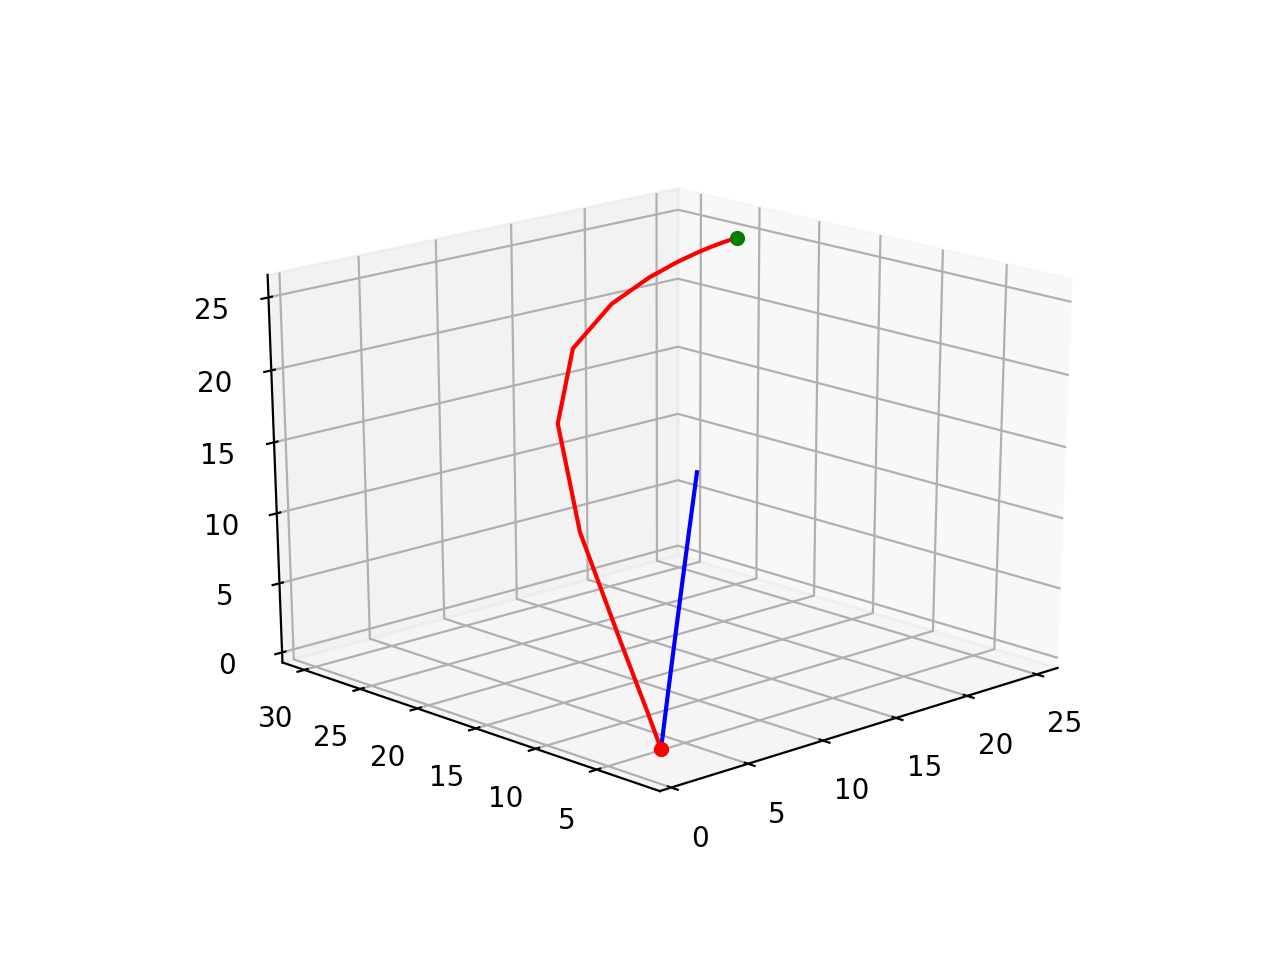

In [7]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(*cgd_trajectory3, 'red')
ax.plot3D(*gda_trajectory3, 'blue')
ax.scatter3D([24.7934], [24.7934], [24.7934], c=['Green']);
ax.scatter3D([x], [y], [z], c=['Red']);